## **Settings**

- Importing all necessary libraries and modules.

In [1]:
import os, sys, random
from sys import platform
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
from monai.utils import set_determinism
from src.helpers.utils import make_dataset, get_device
from src.modules.preprocessing import get_transformations
import src.modules.plotting as plot
from src.modules.training import train_test_splitting, training_model, predict_gnn
from src.helpers.config import get_config
from src.models.gnn import GraphSAGE, GAT, ChebNet

- Definition of paths.

In [2]:
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
graph_path = os.path.join(data_path, _config.get('GRAPH_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	data_path = data_path.replace('/', '\\')
	graph_path = graph_path.replace('/', '\\')
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')

- Ensure reproducibility by setting a seed.

In [3]:
set_determinism(seed=3)
random.seed(3)

- Download of the dataset and splitting in **training**, **evalulation** and **testing** sets.

**NOTES**:

1. The download will start if data are not already present in `data` folder. A valid Synapse authentication token is required in `.env` file.

2. The splitting is carried out on subjects and not on sessions to avoid data leakage problem.

In [4]:
data_folder = make_dataset(dataset='glioma', verbose=False)
train_data, eval_data, test_data = train_test_splitting(data_folder, reports_path=reports_path, load_from_file=True)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            798 (63.79 %)       201 (16.07 %)       252 (20.14 %)       



- Definition of data preprocessing pipelines.

**NOTES**:

1. It assumes that a graph dataset **MUST BE** generated (Please see and run `src/graph_constructor.py` script before executing this notebook).

In [5]:
(
	_, _, _,
	gnn_train_eval_transform,
	gnn_test_transform
) = get_transformations(graph_path = graph_path)

## **Hyperparameter tuning**

- Defining the hyperparameters and ranges for grid-searching the best values combination.

**NOTES**:

1. The values of `hidden_channels` parameter are slightly adapted for `GAT` model due to hardware limitations.

2. Some parameters may be model-specific.

3. To execute the hyperparameter tuning, please refers to `src/hp_tuning.py` script.

In [6]:
plot.hp_ranges()

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
MODEL                                       GRAPHSAGE      RUNs        96
lr                                    [0.0001, 1e-05]
weight_decay                           [1e-05, 1e-06]
dropout                               [0.0, 0.1, 0.5]
hidden_channels                  [256, 256, 256, 256]
                                 [512, 512, 512, 512]
                  [256, 256, 256, 256, 256, 256, 256]
                  [512, 512, 512, 512, 512, 512, 512]
aggr                                  ['mean', 'max']
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
MODEL                                             GAT      RUNs       288
lr                                    [0.0001, 1e-05]
weight_decay                           [1e-05, 1e-06]
dropout                               [0.0, 0.1, 0.5]
hidden_channels                  [256, 256, 256, 256]
                                 [512, 512

- Printing the best parameters configuration.

In [6]:
best_runs = plot.best_config(reports_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
id                               GRAPHSAGE_1738891807
node_dice_score                            0.83201313
lr                                             0.0001
weight_decay                                    1e-06
dropout                                           0.1
hidden_channels   [512, 512, 512, 512, 512, 512, 512]
aggr                                             mean
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
id                                     GAT_1739530363
node_dice_score                            0.70578444
lr                                             0.0001
weight_decay                                    1e-06
dropout                                           0.1
hidden_channels   [512, 512, 512, 512, 512, 512, 512]
heads                                              14
attention_dropout                                 0.1
> > > > > > > > > > > > > > 

## **Training**

- Definition of models best parameters previously searched.

In [20]:
# SHARED PARAMS
num_node_features = 50			# Input feature size
num_classes = 4					# Number of output classes
lr = 1e-4						# Learning rate for the optimizier
weight_decay = 1e-5				# Weight decay for the optimizier
dropout = .0					# Dropout probability (for features)
hidden_channels = [512, 512, 512, 512, 512, 512, 512] # No. of hidden units (input layer included output layer excluded)

# GRAPHSAGE PARAMS
aggr = 'mean'				# Apply pooling operation as aggregator

# GAT PARAMS
heads = 14					# Number of attention heads
attention_dropout = .1		# Dropout probability (for attention mechanism)

# CHEBNET PARAMS
k = 4						# Chebyshev polynomial order

- Setting up the models.

In [21]:
_models = {
	'GraphSAGE': GraphSAGE(
		in_channels = num_node_features,
		hidden_channels = hidden_channels,
		out_channels = num_classes,
		dropout = dropout,
		aggr = aggr
	),
	'GAT': GAT(
		in_channels = num_node_features,
		hidden_channels = hidden_channels,
		out_channels = num_classes,
		dropout = dropout,
		heads = heads,
		attention_dropout = attention_dropout
	),
	'ChebNet': ChebNet(
		in_channels = num_node_features,
		hidden_channels = hidden_channels,
		out_channels = num_classes,
		dropout = dropout,
		K = k
	)
}
model = _models['ChebNet']

- Execution of the training phase.

In [10]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = model,
# 	data = [train_data[:80], eval_data[:20]],
# 	transforms = [gnn_train_eval_transform, gnn_train_eval_transform],
# 	epochs = 10,
# 	device = 'cpu', # get_device(), # 'mps' not supported
# 	paths = [saved_path, reports_path, logs_path, graph_path],
# 	ministep = 4,
# 	batch_size = 10,
# 	verbose = True
# )

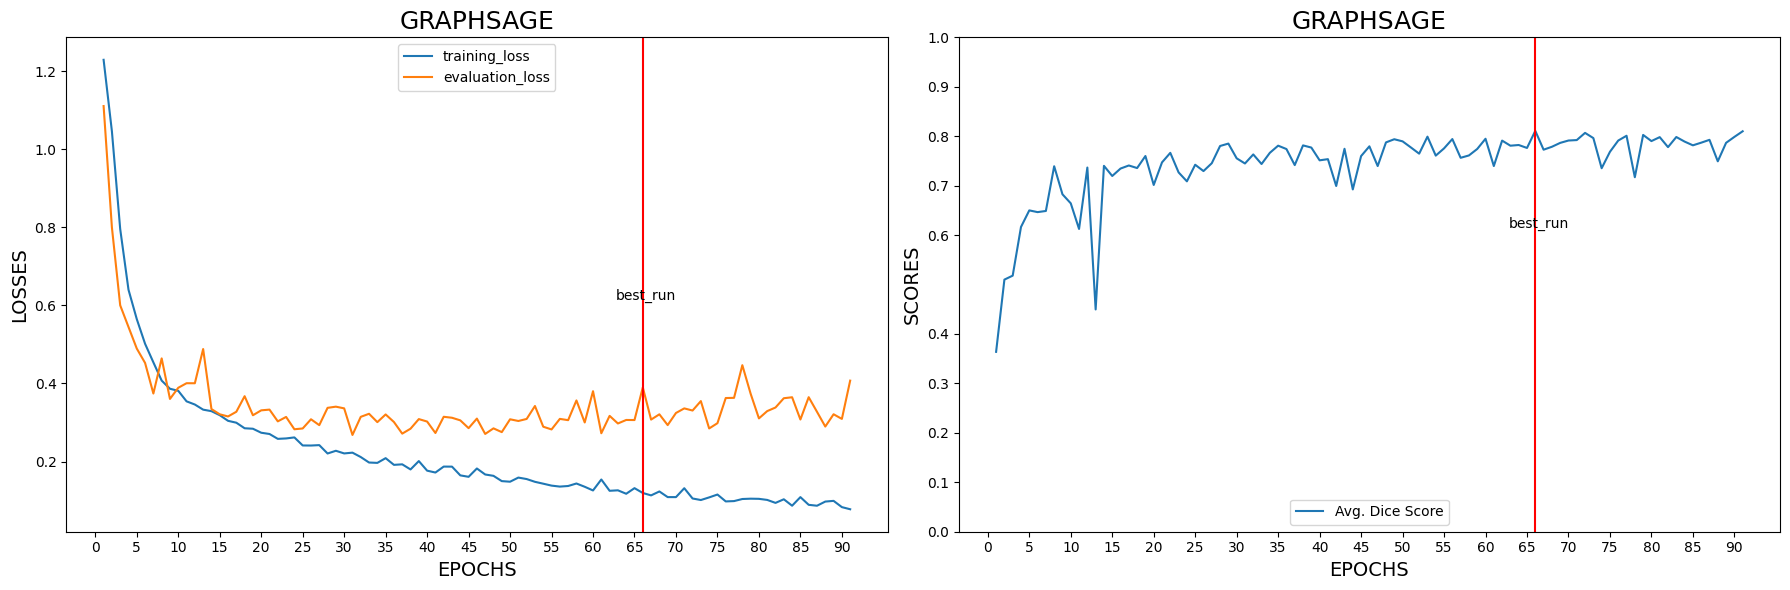

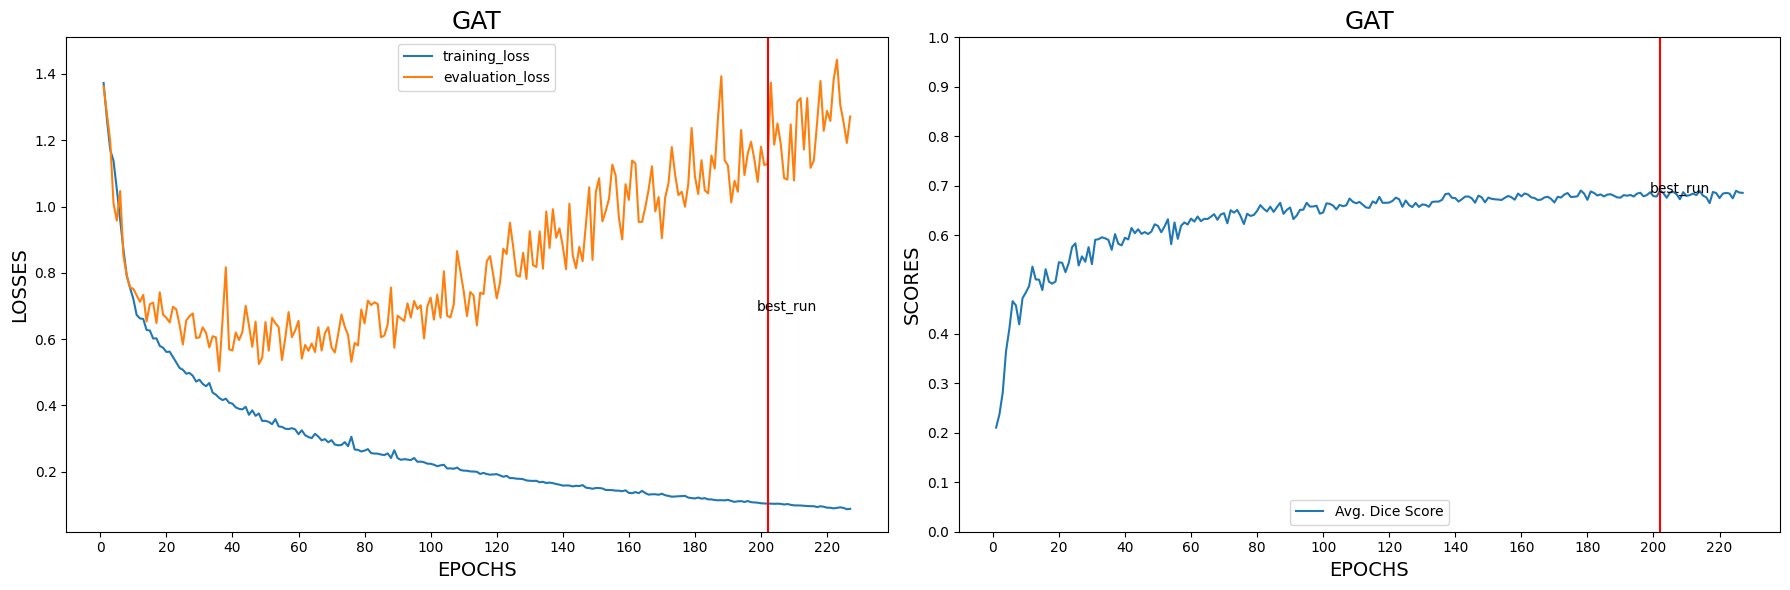

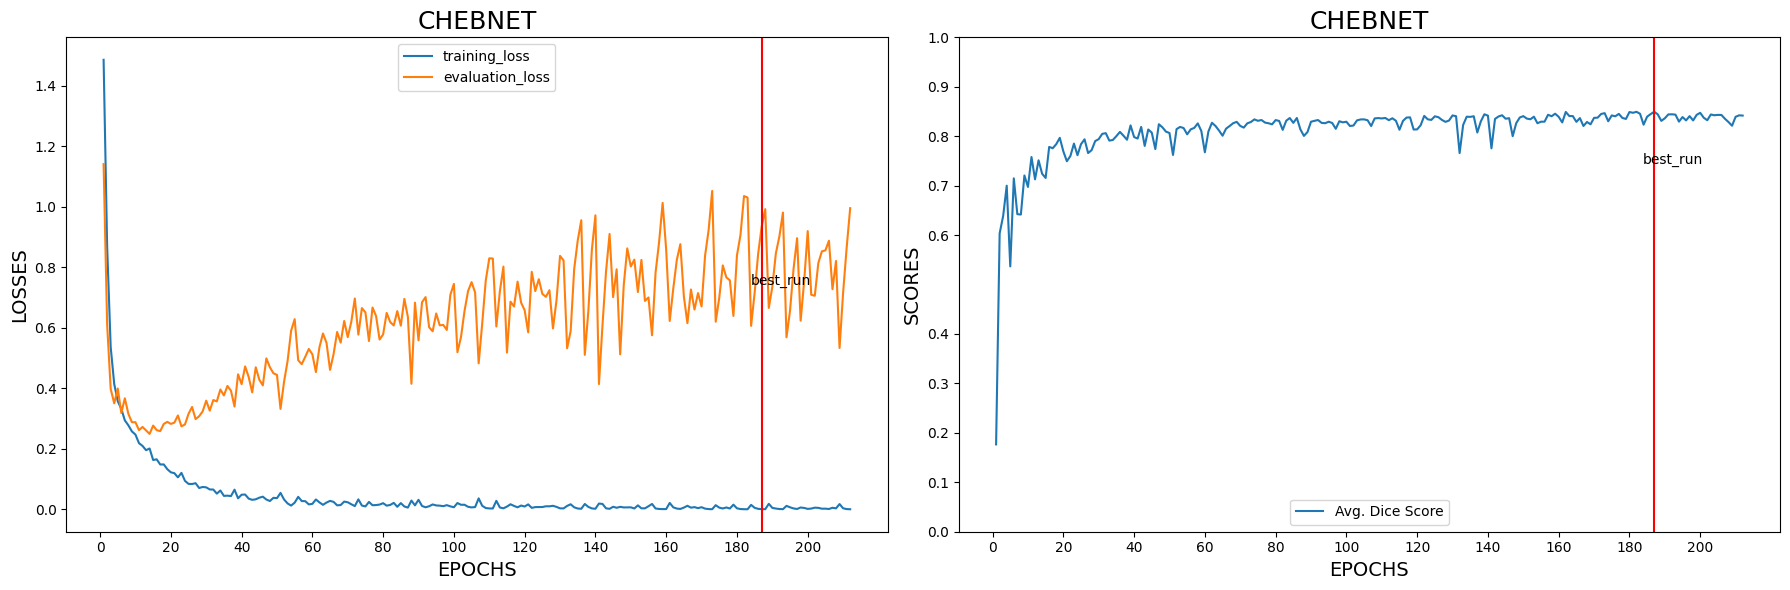

In [11]:
plot.training_values(reports_path, best_runs)

In [1]:
## NOTE: uncomment to execute the prediction on the testing set.

# for i, t in enumerate(test_data):
# 	if i % 50 == 0 and i > 0:
# 		print(f"inference {i}/{len(test_data)}")
# 	test_metrics, predictions = predict_gnn(
# 		model = model,
# 		data = [t],
# 		transforms = gnn_test_transform,
# 		device = 'cpu', # get_device(), # 'mps' not supported
# 		paths = [saved_path, reports_path, logs_path],
# 		return_predictions = True,
# 		verbose = False
# 	)

In [16]:
import pandas as pd

for m in ['GRAPHSAGE_testing.csv', 'GAT_testing.csv', 'CHEBNET_testing.csv']:
	print('\n')
	df = pd.read_csv(os.path.join(reports_path, m), encoding='UTF-8')
	print(df['node_dice_score'].idxmax(), df['dice_score_et'].idxmax(), df['dice_score_tc'].idxmax(), df['dice_score_wt'].idxmax())
	print(df['node_dice_score'].idxmin(), df['dice_score_et'].idxmin(), df['dice_score_tc'].idxmin(), df['dice_score_wt'].idxmin())
	print(df['node_dice_score'].mean(), df['dice_score_et'].mean(), df['dice_score_tc'].mean(), df['dice_score_wt'].mean())
	af = df[(df['node_dice_score'] == .0) | (df['dice_score_et'] == .0) | (df['dice_score_tc'] == .0) | (df['dice_score_wt'] == .0)]
	bad_df = df.index.isin(list(af.index))
	print(af.index)
	print(df[~bad_df]['node_dice_score'].mean(), df[~bad_df]['dice_score_et'].mean(), df[~bad_df]['dice_score_tc'].mean(), df[~bad_df]['dice_score_wt'].mean())




222 208 33 63
53 21 21 28
0.8663031901984127 0.7171376079259928 0.8056600202643682 0.8362553612521243
Index([21, 28, 47, 53, 64, 85, 96, 113, 133, 136, 185, 192, 206, 228, 246], dtype='int64')
0.8784629064978904 0.7625260641238405 0.8420618905799802 0.8521498997188821


49 241 17 213
53 3 3 28
0.7233119491666666 0.5960945382261315 0.7362501314944692 0.7263907395480644
Index([  3,   5,  21,  28,  29,  34,  47,  64,  74,  85, 113, 128, 133, 136,
       145, 185, 192, 206, 228, 240, 246],
      dtype='int64')
0.7333025899134199 0.6502849507921434 0.7795034293488506 0.7363317044072853


138 208 40 176
113 5 5 49
0.8651765097222223 0.7238158661103438 0.8037114013873395 0.8382558344848572
Index([5, 21, 28, 34, 47, 49, 64, 85, 96, 113, 124, 136, 185, 192, 206, 246], dtype='int64')
0.8772448588983053 0.7728881282195196 0.8471736044196759 0.8552161634473477


In [23]:
import pandas as pd

for m in ['GRAPHSAGE_testing.csv', 'GAT_testing.csv', 'CHEBNET_testing.csv']:
	print('\n')
	df = pd.read_csv(os.path.join(reports_path, m), encoding='UTF-8')
	print(df['node_dice_score'].idxmax(), df['dice_score_et'].idxmax(), df['dice_score_tc'].idxmax(), df['dice_score_wt'].idxmax())
	print(df['node_dice_score'].idxmin(), df['dice_score_et'].idxmin(), df['dice_score_tc'].idxmin(), df['dice_score_wt'].idxmin())
	print(df['node_dice_score'].mean(), df['dice_score_et'].mean(), df['dice_score_tc'].mean(), df['dice_score_wt'].mean())
	af = df[(df['node_dice_score'] == .0) | (df['dice_score_et'] == .0) | (df['dice_score_tc'] == .0) | (df['dice_score_wt'] == .0)]
	bad_df = df.index.isin(list(af.index))
	print(af.index)
	print(df[~bad_df]['node_dice_score'].mean(), df[~bad_df]['dice_score_et'].mean(), df[~bad_df]['dice_score_tc'].mean(), df[~bad_df]['dice_score_wt'].mean())




93 4 40 63
180 5 5 113
0.8320129986111111 0.6994314814015986 0.7779906819027568 0.8048852949684101
Index([  5,  21,  28,  29,  31,  47,  64,  74,  85,  96, 113, 136, 180, 185,
       192, 206, 222, 228, 232, 246, 257, 273, 280, 281, 283, 299, 316, 326,
       337, 348, 365, 388, 432, 437, 444, 458, 474, 480, 484, 498],
      dtype='int64')
0.8512828406034483 0.7597272987638054 0.8277430414896587 0.8242275213886952


96 208 208 93
53 5 5 28
0.7057844681746032 0.5907192787318121 0.7276795803170119 0.7099447454074546
Index([  5,  12,  21,  28,  29,  34,  47,  52,  53,  64,  74,  85,  98, 113,
       128, 133, 136, 145, 185, 192, 206, 222, 228, 232, 246],
      dtype='int64')
0.7231336026431717 0.6557764680194565 0.7846702019876846 0.7313223976133153


153 208 40 176
232 21 21 49
0.8618581827380952 0.7135211972017137 0.7991616091439648 0.8347514716257888
Index([21, 28, 31, 47, 49, 64, 74, 85, 96, 113, 124, 133, 136, 185, 192, 206,
       222, 246],
      dtype='int64')
0.8767078403846154

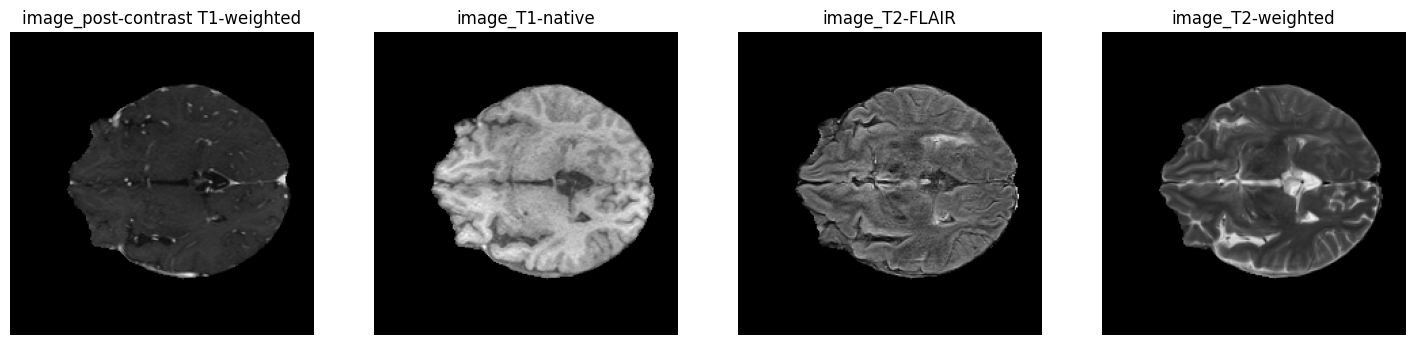

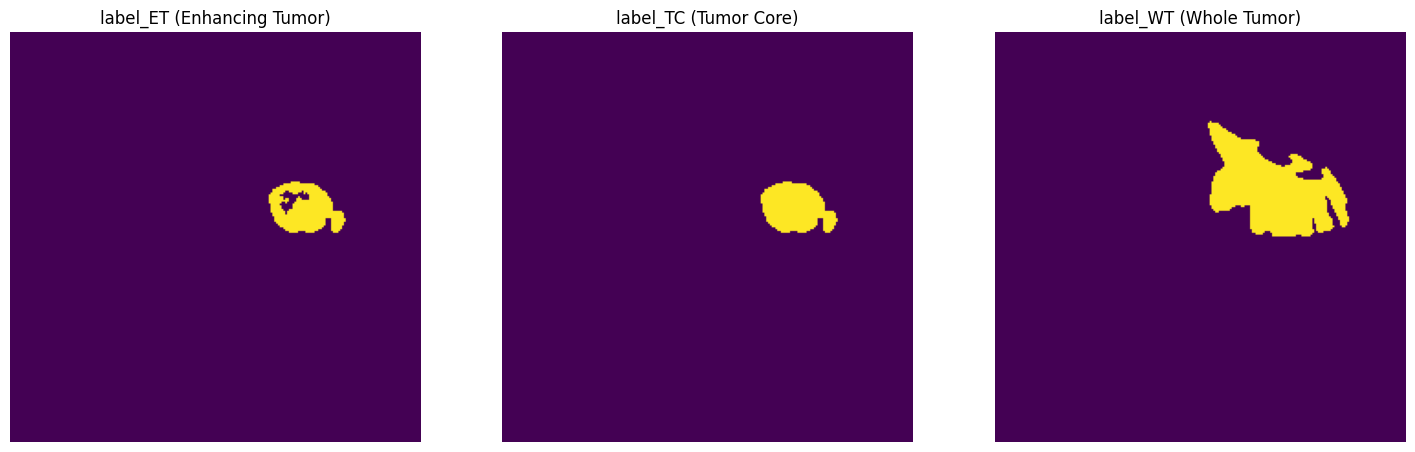

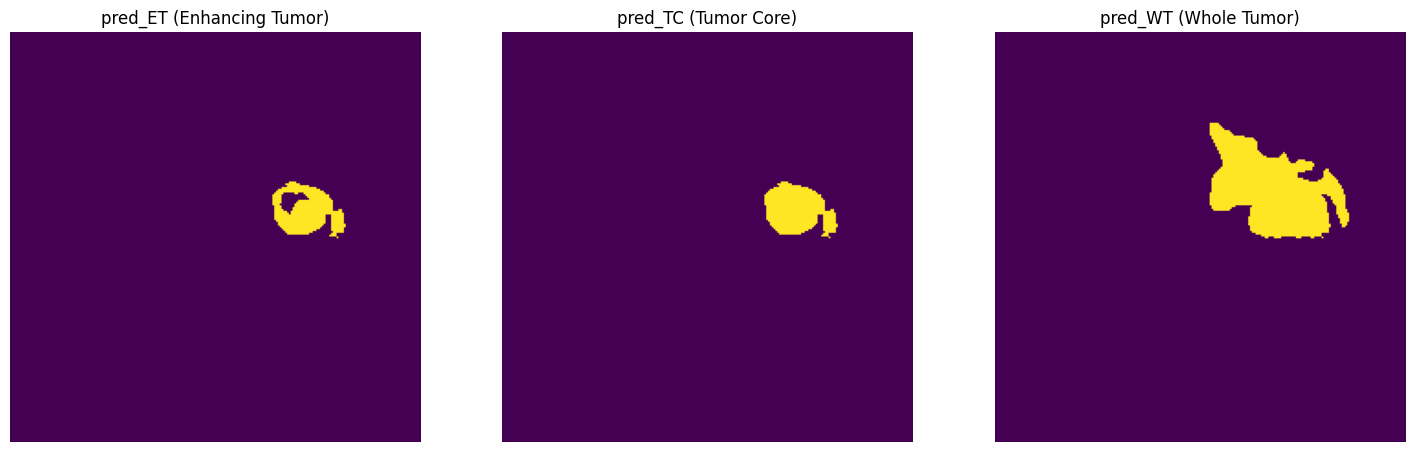

In [35]:
example = test_data[63] # 33, 63
trans_test_data = gnn_test_transform(example)
test_metrics, preds = predict_gnn(
	model = model,
	data = [example],
	transforms = gnn_test_transform,
	device = 'cpu', # get_device(), # 'mps' not supported
	paths = [saved_path, reports_path, logs_path],
	write_to_file = False
)
plot.prediction(data = [
	trans_test_data['image'].numpy(), trans_test_data['label'].numpy(), preds[0]
])